In [2]:
import os
from dotenv import dotenv_values, load_dotenv, find_dotenv
import settings as settings
from statsmodels.tsa.seasonal import seasonal_decompose
from utilities import dataframegenerator as gendf
import psycopg2
from utilities import config
from evaluation import forecast_metrics as fm
from datetime import timedelta
import datetime
from tools import dataexplore as dtexp
from fbprophet import Prophet
from fbprophet.plot import plot_seasonality as plt_seas
# from fbprophet.plot import plot_forecast_component as plt_fcst
# from fbprophet.diagnostics import cross_validation as cv
# from fbprophet.diagnostics import performance_metrics as pm
# from fbprophet.plot import plot_cross_validation_metric, plot_seasonality
from tools import datacleaner as dtclean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tools import data_visualization as dtview
from plotly.offline import init_notebook_mode, iplot
import warnings
import seaborn as sns
import src.read_large_files as read_large_files
plt.style.use('ggplot')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
table_from_database = 'nocovid_dataset.csv' # set csv file name to read from csv in folder named data namecsvfile.csv
path = str(settings.settings.get('PATH'))[:-5]
csvpath = path + str(settings.settings.get('CSVPATH'))[-15:]
imgpath = path + str(settings.settings.get('IMGPATH'))[-4:]
jptimgpath = getattr(config,'jptimgpath','default_value')
jptcsvpath = getattr(config,'jptcsvpath','default_value')

df_h_cli, df_d_cli = gendf.get_dataset_to_forecast(table_from_database)

        id             datetime  store    weekday  sales  products_sold  \
0        1  2020-03-18 08:30:00    274  wednesday    896            208   
1        2  2020-03-18 09:00:00    274  wednesday    954            202   
2        3  2020-03-18 09:30:00    274  wednesday   1243            254   
3        4  2020-03-18 10:00:00    274  wednesday    580            130   
4        5  2020-03-18 10:30:00    274  wednesday    584            130   
...    ...                  ...    ...        ...    ...            ...   
1745  1746  2020-05-26 18:30:00    274    tuesday   1541            309   
1746  1747  2020-05-26 19:00:00    274    tuesday    776            123   
1747  1748  2020-05-26 19:30:00    274    tuesday   1060            253   
1748  1749  2020-05-26 20:00:00    274    tuesday   1217            316   
1749  1750  2020-05-26 20:30:00    274    tuesday   1346            262   

      clientes_that_bought  half_hour  year  month  dia  
0                       30         17  20

In [4]:
table_with_zeroes = 'nocovid_dataset_zeroes.csv' # set csv file name to read from csv in folder named data namecsvfile.csv
df_h_cli_zeroes, df_d_cli_zeroes = gendf.get_dataset_to_forecast(table_with_zeroes) # always return 2 dataframes (hourly and daily)

        id             datetime    weekday  clientes_that_bought  store
0        1  2020-03-18 08:30:00  wednesday                    30    274
1        2  2020-03-18 09:00:00  wednesday                    41    274
2        3  2020-03-18 09:30:00  wednesday                    36    274
3        4  2020-03-18 10:00:00  wednesday                    26    274
4        5  2020-03-18 10:30:00  wednesday                    21    274
...    ...                  ...        ...                   ...    ...
3332  3292  2020-05-25 22:00:00     monday                     0    274
3333  3293  2020-05-25 22:30:00     monday                     0    274
3334  3294  2020-05-25 23:00:00     monday                     0    274
3335  3295  2020-05-25 23:30:00     monday                     0    274
3336  3296  2020-05-26 00:00:00     monday                     0    274

[3337 rows x 5 columns]


# Preparing train and test dataframe for hourly prediction - Nr. of Client

In [5]:
df_274_cli_treino, df_274_cli_teste = dtexp.configura_dataframe_treino_teste(df_h_cli,
                                                                             inicio='2020-03-18 08:30:00',
                                                                             fim='2020-04-28 20:30:00',
                                                                             data_final='2020-05-26 20:30:00')
df_274_cli_treino = df_274_cli_treino.groupby('ds').sum()
df_274_cli_treino.reset_index(level=0,inplace=True)
df_274_cli_treino.ds = pd.to_datetime(df_274_cli_treino.ds)
df_274_cli_treino.index = df_274_cli_treino.ds


# Preparing train and test dataframe for daily prediction - Nr. of Client

In [6]:
df_274_d_cli_treino, df_274_d_cli_teste = dtexp.configura_dataframe_treino_teste(df_d_cli,
                                                                             inicio='2020-03-18 08:30:00',
                                                                             fim='2020-04-28 20:30:00',
                                                                             data_final='2020-05-26 20:30:00')
df_274_d_cli_treino = df_274_d_cli_treino.groupby('ds').sum()
df_274_d_cli_treino.reset_index(level=0,inplace=True)
df_274_d_cli_treino.ds = pd.to_datetime(df_274_d_cli_treino.ds)
df_274_d_cli_treino.index = df_274_d_cli_treino.ds


# Prediction for quantity of client hourly

In [7]:
threshold_date = pd.to_datetime('2020-04-29 08:00:00')
df_274_cli_treino, df_274_cli_teste = dtexp.split_dataframe(df_h_cli,threshold_date=threshold_date)
hist_size = int(np.floor(df_274_cli_treino.shape[0] * 0.8))
n_changepoints = hist_size-1
n_changepoints
df_274_cli_treino.tail(3)


ds   y
1047 2020-04-28 19:30:00  17
1048 2020-04-28 20:00:00  10
1049 2020-04-28 20:30:00  16

In [8]:
df_h_cli['ds'].max() - df_h_cli['ds'].min()

Timedelta('69 days 12:00:00')

In [9]:
alpha=0.8
mdl_prophet = Prophet(growth = 'linear',
                      interval_width=alpha,
                      changepoint_prior_scale=0.0001,
                      #holidays_prior_scale=0.01,
                      #seasonality_prior_scale=0.0001,
                      changepoint_range=0.4,
                      seasonality_mode="additive")

#mdl_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
mdl_prophet.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
mdl_prophet.fit(df_274_cli_treino)

future_clientes = mdl_prophet.make_future_dataframe(periods=29, freq='30min')

future_clientes['ds'] = pd.to_datetime(future_clientes['ds'])
future_clientes = future_clientes.set_index(pd.DatetimeIndex(future_clientes['ds']))
future_clientes = future_clientes.set_index(pd.DatetimeIndex(future_clientes['ds']))
# Instead of adding 0 do this On the half-hourly predictions, due to the higher temporal resolution and in order to obtain better results some changes in the parameters ocurred. The changepoint_prior_scale is the regularizer of the effects that changepoints cause in the TS. Prophet assumes that the trend’s magnitude is modified at each changepoint. By leaving the default values for n_changepoint (parameter that specifies the number of changepoints), Prophet assumes a fixed value of 80% of historical data, which in the case study represents 839 changepoints in the training data set, setting the changepoint_prior_scale to a lower value, in each changepoint the trend may change in a smaller amount, therefore, less total change and less flexibility of the trend but concentrated in the same number of changepoints. on future dataframe
future_clientes = future_clientes.between_time('08:30','20:30')
forecast_clientes = mdl_prophet.predict(future_clientes)
iplot(dtview.plot_forecast_as_table(forecast_clientes))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


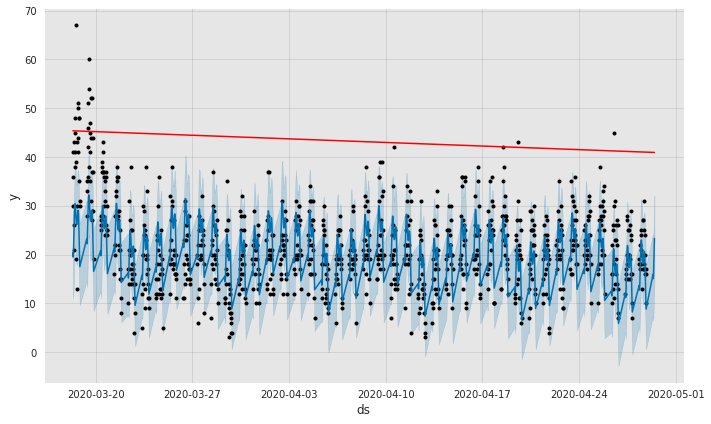

In [10]:
from fbprophet.plot import add_changepoints_to_plot
fig = mdl_prophet.plot(forecast_clientes)
a = add_changepoints_to_plot(fig.gca(), mdl_prophet, forecast_clientes)

# Ploting change points

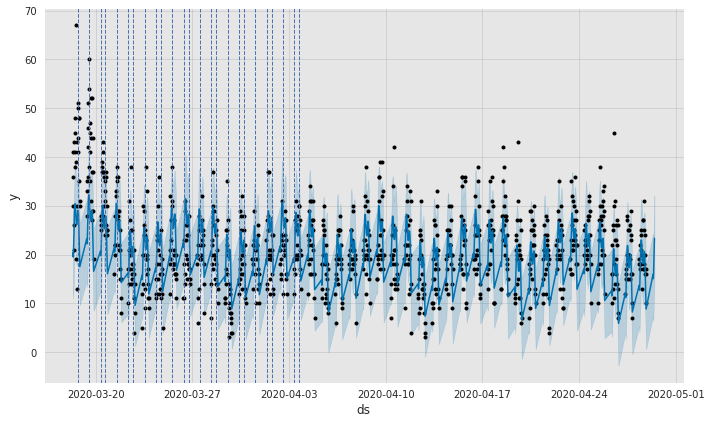

In [11]:

figure = mdl_prophet.plot(forecast_clientes)
for changepoint in mdl_prophet.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

# Checking model parameters

In [12]:
mdl_prophet.params

{'k': array([[-0.06528315]]),
 'm': array([[0.67723171]]),
 'delta': array([[-2.53348216e-11, -1.75939292e-11, -3.39630593e-11,
          2.50808247e-11,  1.37415741e-11, -3.79255483e-11,
          4.42625602e-11, -1.83458740e-11, -1.86324346e-11,
         -4.76785255e-11,  2.00275125e-11, -3.34369735e-11,
         -5.84293594e-12, -4.36269123e-11,  2.56554359e-11,
          3.45103387e-11,  8.95504697e-12,  4.22936995e-11,
         -2.35272975e-11,  2.55013364e-11,  5.60071384e-12,
          4.38763987e-11,  7.71087348e-12, -4.19106921e-12,
          2.27609785e-11]]),
 'sigma_obs': array([[0.09706154]]),
 'beta': array([[ 0.42288276,  0.37864347,  0.43654523,  0.00493487,  0.13800475,
         -0.12864215,  0.03171626,  0.03666439, -0.00783208, -0.00059967,
          0.00673514,  0.01699537]]),
 'trend': array([[0.67723171, 0.67719893, 0.67716616, ..., 0.6120141 , 0.61198133,
         0.61194856]])}

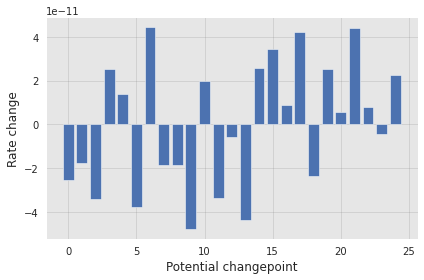

In [13]:
mdl_prophet.params.keys()
deltas = mdl_prophet.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [14]:
threshold_date='2020-04-29'
threshold_date = pd.to_datetime(threshold_date)
df_274_cli_treino, df_274_cli_teste = dtexp.split_dataframe(df_h_cli,threshold_date=threshold_date)
hist_size = int(np.floor(df_274_cli_treino.shape[0] * 0.8))
n_changepoints = hist_size-1
n_changepoints

839

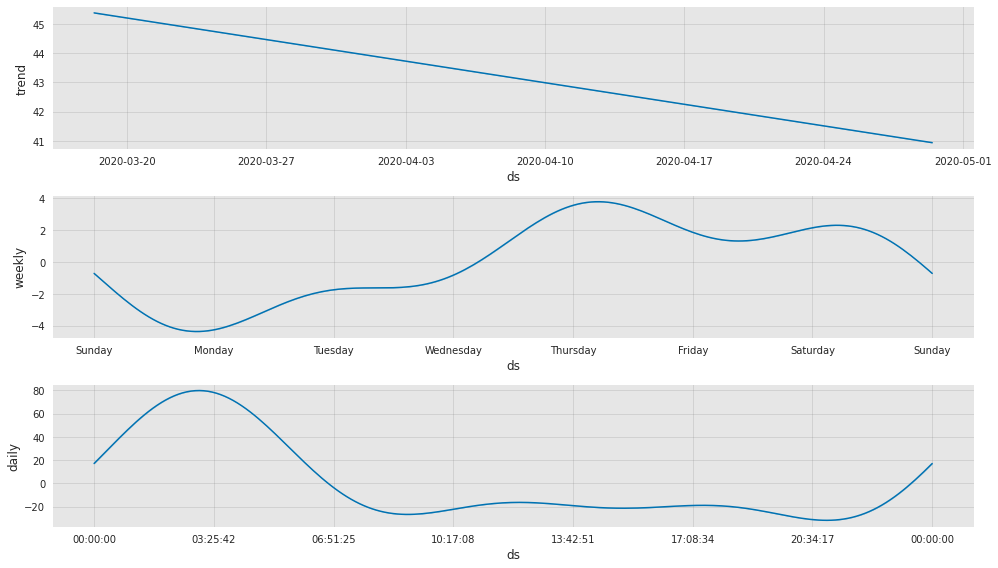

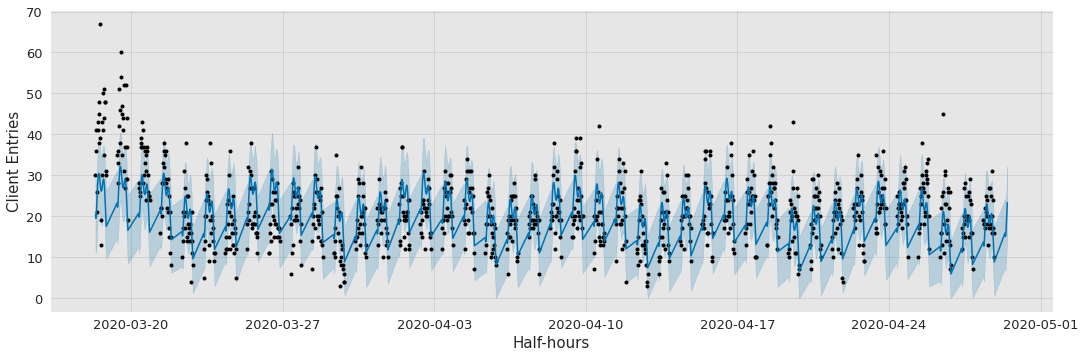

In [15]:
forecast_clientes = dtclean.remove_forecast_negative_values(forecast_clientes)
fig = mdl_prophet.plot_components(forecast_clientes, figsize=(14,8))
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mdl_prophet.plot(forecast_clientes,ax=ax, figsize=(10,6))
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel("Half-hours", fontsize=15)

ax.set_ylabel("Client Entries", fontsize=15);


for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'hourly_prophet_seasonality_comparison_with_30mins_freqs.{ext}', dpi=200)

plt.show()

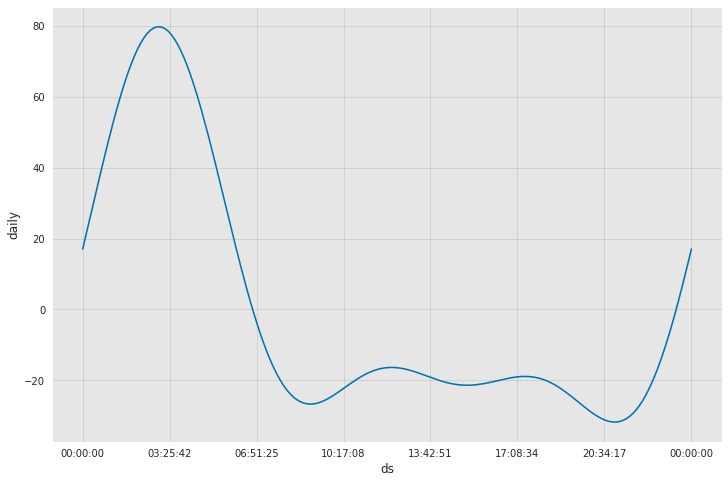

In [16]:
plt_seas(mdl_prophet, name='daily',figsize=(12,8))
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'hourly_prophet_seasonality_30m_freqs.{ext}', dpi=200)

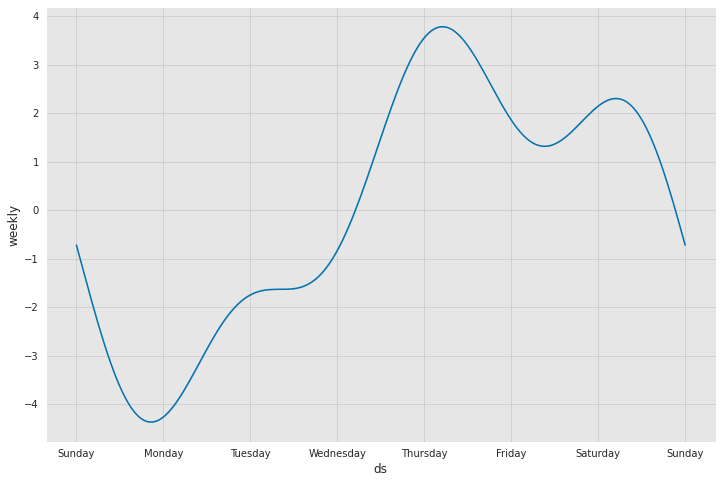

In [17]:
plt_seas(mdl_prophet, name='weekly',figsize=(12,8))
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'Hourly_weekly_plot_prophet_seasonality_30m_freqs.{ext}', dpi=200)

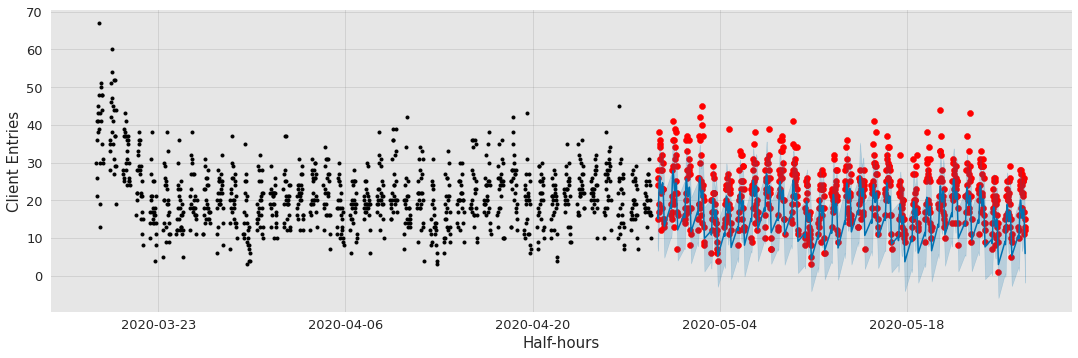

In [18]:
df_274_clients_teste_n = df_274_cli_teste.copy()
df_274_clients_teste_n['ds'] = pd.to_datetime(df_274_clients_teste_n['ds'])
df_274_clients_teste_n = df_274_clients_teste_n.set_index(pd.DatetimeIndex(df_274_clients_teste_n['ds']))
df_274_clients_teste_forecast = mdl_prophet.predict(df_274_clients_teste_n)
mape = fm.mape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
maape = fm.maape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste_n.ds,df_274_clients_teste_n['y'], color='r')

fig = mdl_prophet.plot(df_274_clients_teste_forecast,ax=ax,figsize=(10,6))
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel("Half-hours", fontsize=15)

ax.set_ylabel("Client Entries", fontsize=15);

for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'hourly_TestXForecasted_comparison.{ext}', dpi=200)
plt.show()

# Ploting the hourly train and test datasets

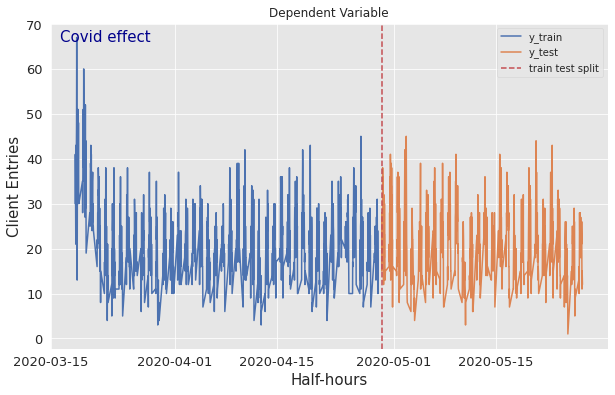

In [19]:
threshold_date='2020-04-29 08:00:00'
threshold_date = pd.to_datetime(threshold_date)
parameters = {'ytick.labelsize': 15,'xtick.labelsize': 15, 'axes.titlesize':12}
plt.rcParams.update(parameters)

#rows, cols = df_274_d_cli_treino.shape
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='ds', y='y', label='y_train', data=df_274_cli_treino, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_274_cli_teste, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel("Half-hours", fontsize=15)

ax.set_ylabel("Client Entries", fontsize=15)

ax.text(0.1, 0.98, 'Covid effect',
        verticalalignment='top', horizontalalignment='center',
        transform=ax.transAxes,
        color='darkblue', fontsize=15)
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'hourly_train_test_set.{ext}', dpi=200)
plt.show()

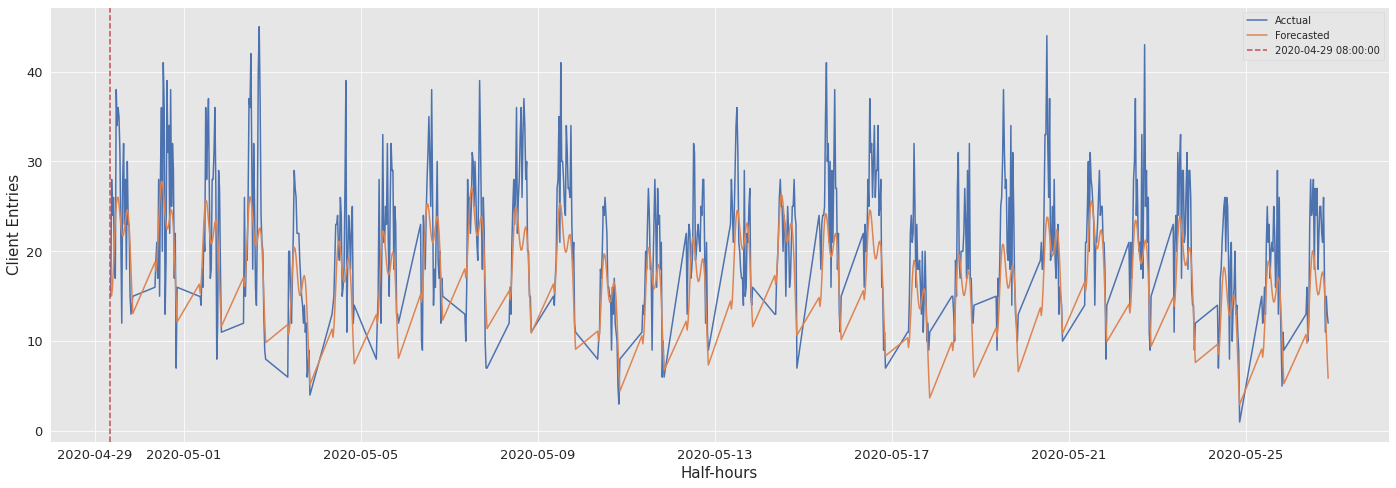

In [20]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(x='ds', y='y', label='Acctual', data=df_274_clients_teste_n, ax=ax)
sns.lineplot(x='ds', y='yhat', label='Forecasted', data=df_274_clients_teste_forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label=threshold_date)#'train test split')
ax.legend(loc='upper right')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel("Half-hours", fontsize=15)

ax.set_ylabel("Client Entries", fontsize=15);

for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'hourly_RealXForecasted_comparison_scatter.{ext}', dpi=200)
plt.show()

# Saving hourly metrics

In [21]:
mape_h = fm.mape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
maape_h = fm.maape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
rmse_h = fm.rmse(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
mae_h = fm.mae(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))

df_metrics = pd.DataFrame(data={'MAPE': mape_h,
                               'MAAPE': maape_h,
                                'RMSE': rmse_h,
                                'MAE': mae_h},index=[0])
df_metrics.to_csv(csvpath+'/'+'metrics_hourly.csv')
df_metrics


MAPE     MAAPE      RMSE       MAE
0  0.245764  0.231932  6.464409  5.119943

### Adds a time index and scales y. Creates auxiliary columns 't', 't_ix',
        'y_scaled', and 'cap_scaled'. These columns are used during both
        fitting and predicting.
        Parameters
        ----------
        df: pd.DataFrame with columns ds, y, and cap if logistic growth. Any
            specified additional regressors must also be present.
        initialize_scales: Boolean set scaling factors in self from df.
        Returns
        -------
        pd.DataFrame prepared for fitting or predicting.

In [22]:
df_prepared_to_stan = mdl_prophet.setup_dataframe(df_h_cli)
df_prepared_to_stan

index                  ds    weekday   y  store  floor         t  \
0         0 2020-03-18 08:30:00  wednesday  30    274      0  0.000000   
1         1 2020-03-18 09:00:00  wednesday  41    274      0  0.000502   
2         2 2020-03-18 09:30:00  wednesday  36    274      0  0.001004   
3         3 2020-03-18 10:00:00  wednesday  26    274      0  0.001506   
4         4 2020-03-18 10:30:00  wednesday  21    274      0  0.002008   
...     ...                 ...        ...  ..    ...    ...       ...   
1745   1745 2020-05-26 18:30:00    tuesday  17    274      0  1.672691   
1746   1746 2020-05-26 19:00:00    tuesday  11    274      0  1.673193   
1747   1747 2020-05-26 19:30:00    tuesday  15    274      0  1.673695   
1748   1748 2020-05-26 20:00:00    tuesday  13    274      0  1.674197   
1749   1749 2020-05-26 20:30:00    tuesday  12    274      0  1.674699   

      y_scaled  
0     0.447761  
1     0.611940  
2     0.537313  
3     0.388060  
4     0.313433  
...        ...  
1745  0.253731  
1746  0.164179  
1747  0.223881  
1748  0.194030  
1749  0.179104  

[1750 rows x 8 columns]

In [23]:
df_prepared_to_stan.y_scaled.describe()

count    1750.000000
mean        0.319267
std         0.120793
min         0.014925
25%         0.238806
50%         0.313433
75%         0.388060
max         1.000000
Name: y_scaled, dtype: float64

# Observing the model

In [24]:
mdl_prophet.t_scale

Timedelta('41 days 12:00:00')

# Observing the model seasonality

In [25]:
mdl_prophet.seasonalities

OrderedDict([('daily',
              {'period': 1,
               'fourier_order': 3,
               'prior_scale': 0.7,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [26]:
mdl_prophet.start

Timestamp('2020-03-18 08:30:00')

# Observing stan

In [ ]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5944b02c79788fa0db5b3a93728ca2bf NOW.


In [ ]:
model.vb()

In [27]:
#import sympy



In [ ]:
plt.figure(figsize=(10,4))

x = df_274_clients_teste_forecast.ds.values
y = df_274_clients_teste_forecast.trend.values
cp = mdl_prophet.changepoints

plt.plot(x,y)
ymin, ymax = plt.ylim()
plt.vlines(cp.values, ymin, ymax, linestyles="dashed")

# Prediction for quantity of client. Daily

In [ ]:
threshold_date='2020-04-29'
threshold_date = pd.to_datetime(threshold_date)
df_274_d_cli_treino, df_274_d_cli_teste = dtexp.split_dataframe(df_d_cli,threshold_date=threshold_date)
hist_size = int(np.floor(df_274_d_cli_treino.shape[0] * 0.9))
n_changepoints = hist_size-1
n_changepoints

In [ ]:
parameters = {'ytick.labelsize': 15,'xtick.labelsize': 15, 'axes.titlesize':15}
plt.rcParams.update(parameters)
df_274_d_cli_treino=df_274_d_cli_treino.groupby('ds').sum()
df_274_d_cli_treino.reset_index(level=0, inplace=True)
df_274_d_cli_treino.ds = pd.to_datetime(df_274_d_cli_treino.ds)
df_274_d_cli_treino.index=df_274_d_cli_treino.ds
df_274_d_cli_treino.y.plot(figsize=(10,6), xlabel="Days", ylabel="Client Entries")
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_RealXForecasted_comparison_scatter.{ext}', dpi=200)
plt.show()

# Test dataset daily grouped

In [ ]:
df_274_d_cli_teste.reset_index(level=0, inplace=True)
df_274_d_cli_teste.ds = pd.to_datetime(df_274_d_cli_teste.ds)
df_274_d_cli_teste.index=df_274_d_cli_teste.ds
df_274_d_cli_teste.y.plot(figsize=(10,6), xlabel="Days", ylabel="Client Entries")
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_test.{ext}', dpi=200)

plt.show()

In [ ]:
threshold_date = pd.to_datetime(threshold_date)
fig, ax = plt.subplots(figsize=(10,6))
parameters = {'ytick.labelsize': 15,'xtick.labelsize': 15, 'axes.titlesize':12}
plt.rcParams.update(parameters)
sns.lineplot(x='ds', y='y', label='y_train', data=df_274_d_cli_treino, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_274_d_cli_teste, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable', xlabel="Days", ylabel="Client Entries")
ax.text(0.1, 0.98, 'Covid effect',
        verticalalignment='top', horizontalalignment='center',
        transform=ax.transAxes,
        color='darkblue', fontsize=15)
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_train_test_set.{ext}', dpi=200)
plt.show()

In [ ]:
alpha=0.8
mdl_prophet_d_cli = Prophet(interval_width=alpha,
                      #changepoint_prior_scale=0.01,
                      #seasonality_prior_scale=0.01,
                      #changepoint_range=0.9,
                      seasonality_mode="additive",
                      yearly_seasonality=False)
#mdl_prophet_d_cli.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
#mdl_prophet_d_cli.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
#mdl_prophet_d_cli.add_seasonality(name='hourly', period=1/24, fourier_order=3, prior_scale=0.7)

mdl_prophet_d_cli.fit(df_274_d_cli_treino)

future_d_clientes = mdl_prophet_d_cli.make_future_dataframe(periods=29, freq='1D')
# Removendo valores fora do range de atendimento da loja (22:30 - 05:59)fig = prophet.plot_components(forecast_clientes, figsize=(12,8))
future_d_clientes['ds'] = pd.to_datetime(future_d_clientes['ds'])
future_d_clientes = future_d_clientes.set_index(pd.DatetimeIndex(future_d_clientes['ds']))
forecast_d_clientes = mdl_prophet_d_cli.predict(future_d_clientes)
iplot(dtview.plot_forecast_as_table(forecast_d_clientes))

# Viewing the Time Series Components

In [ ]:
plt_seas(mdl_prophet_d_cli, name='weekly',figsize=(12,8))
for ext in ['png','jpeg','pdf']: 
    plt.savefig(jptimgpath+'/'+f'Daily_weekly_plot_prophet_seasonality.{ext}', dpi=200)
plt.show()

# Not necessary since it uses the built in seasonality

plt_seas(mdl_prophet_d_cli, name='daily',figsize=(12,8))
for ext in ['png','jpeg','pdf']: 
    plt.savefig(jptimgpath+'/'+f'Daily_daily_plot_prophet_seasonality.{ext}', dpi=200)
plt.show()

In [ ]:
forecast_d_clientes = dtclean.remove_forecast_negative_values(forecast_d_clientes)
fig = mdl_prophet_d_cli.plot_components(forecast_d_clientes, figsize=(10,6))

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = mdl_prophet_d_cli.plot(forecast_d_clientes,ax=ax,figsize=(10,6), xlabel="Days", ylabel="Client Entries")
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_forecast_components.{ext}', dpi=200)

plt.show()


In [ ]:

mask = df_d_cli['ds'] < threshold_date
df = gendf.prep_dataframe_components(df_d_cli)
decomposition_obj = seasonal_decompose(
    x=df_274_d_cli_treino.set_index('ds'),
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Observed time series.
decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
# Trend component. 
decomposition_obj.trend.plot(label='fit', ax=ax[1])
df[mask][['ds', 'trend']].set_index('ds').plot(c=sns_c[1], ax=ax[1])
ax[1].legend(loc='lower right')
ax[1].set(title='trend')
# Seasonal component. 
decomposition_obj.seasonal.plot(label='fit', ax=ax[2])
df.assign(seasonal = lambda x: x['yearly_seas'] + x['monthly_seas'] + x['end_of_year']) \
    [mask][['ds', 'seasonal']] \
    .set_index('ds')\
    .plot(c=sns_c[2], ax=ax[2])
ax[2].legend(loc='lower right')
ax[2].set(title='seasonal')
# Residual.
decomposition_obj.resid.plot(label='fit', ax=ax[3])
df[mask][['ds', 'noise']].set_index('ds').plot(c=sns_c[3], ax=ax[3])
ax[3].legend(loc='lower right')
ax[3].set(title='residual')

fig.suptitle('Time Series Decomposition', y=1.01)
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_seasonality_components_comparison.{ext}', dpi = 200)
plt.tight_layout()

In [ ]:
df_274_clients_teste_n = df_274_d_cli_teste.copy()
df_274_clients_teste_n['ds'] = pd.to_datetime(df_274_clients_teste_n['ds'])
df_274_clients_teste_n = df_274_clients_teste_n.set_index(pd.DatetimeIndex(df_274_clients_teste_n['ds']))
df_274_clients_teste_forecast = mdl_prophet_d_cli.predict(df_274_clients_teste_n)
mape = fm.mape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
maape = fm.maape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste_n.ds,df_274_clients_teste_n['y'], color='r')
fig = mdl_prophet_d_cli.plot(df_274_clients_teste_forecast,ax=ax)
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_TestXForecasted_comparison.{ext}', dpi = 200)
plt.show()

In [ ]:
fig = iplot(dtview.compare_dataframes_with_bar(
    df_274_clients_teste_n,
    df_274_clients_teste_forecast,
    nametrace1='Real Values',
    nametrace2='Forecasted Values',
    idx_end=28))
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_RealXForecasted_comparison_bar.{ext}', dpi = 200)
plt.show()

In [ ]:
fig=iplot(dtview.compare_dataframes_with_scatter(df_274_clients_teste_n,
                                   df_274_clients_teste_forecast,
                                   title='Forecast quantity of clients vs actual quantity',
                                    mode='lines',
                                   name1='Test',
                                   name2='Forecasted',
                                   mape=str(round(mape,3)),
                                   maape=str(round(maape,3)),
                                  is_forecast=True))
for ext in ['png','jpeg','pdf']:
    plt.savefig(jptimgpath+'/'+f'daily_RealXForecasted_comparison_scatter_mape_maape.{ext}', dpi = 200)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(x='ds', y='y', label='Acctual', data=df_274_clients_teste_n, ax=ax)
sns.lineplot(x='ds', y='yhat', label='Forecasted', data=df_274_clients_teste_forecast, ax=ax)
#ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel("Days", fontsize=15)

ax.set_ylabel("Client Entries", fontsize=15);

for ext in ['png','jpeg','pdf']: 
    plt.savefig(jptimgpath+'/'+f'daily_RealXForecasted_comparison_scatter.{ext}', dpi=200)
plt.show()

In [ ]:
# Visualizando a previsão e os dados originais
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_clients_teste_n.ds, df_274_clients_teste_n['y'], color='r')
fig = mdl_prophet_d_cli.plot(df_274_clients_teste_forecast, ax=ax)
ax.set_ylim(10, 1000)
plot = plt.suptitle('May last week - Predicted vs Actual')

## Saving daily metrics

In [ ]:
mape = fm.mape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
maape = fm.maape(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
rmse = fm.rmse(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))
mae = fm.mae(np.array(df_274_clients_teste_n['y']),np.array(df_274_clients_teste_forecast['yhat']))

df_metrics = pd.DataFrame(data={'MAPE': mape,
                               'MAAPE': maape,
                                'RMSE': rmse,
                                'MAE': mae},index=[0])
df_metrics.to_csv(jptcsvpath+'/'+'metrics_daily.csv')

In [ ]:
df_metrics

In [ ]:
print(mdl_prophet_d_cli.params)

In [ ]:
mdl_prophet_d_cli.params

In [ ]:
m = Prophet()
m.fit(df_274_cli_treino)
fcast = m.predict()
m.params

In [ ]:
from IPython.display import Image
Image(jptimgpath+'/Prophet_data_preparation_diagram.png')

In [ ]:
Image("img/make_all_seasonality_features.png")

# From this point on there are lots of tests and are not stable yet
 
## Preparing dataframe for regressors

# In construction

df_wh_sp_pr = gendf.get_dataframe('wh_condition_sp_pr_2020')
df_wh_sp_pr.head()

# Join with the actual observations

In [49]:
#utils.median_filter?
#verif = utils.make_verif(df_274_clients_teste_forecast, df_274_d_cli_treino, df_274_clients_teste_n)
#f = utils.plot_verif(verif)

# Scatter plot, marginal distribution and correlation between observations and modelled / predicted values

## Train set

In [50]:
#utils.plot_joint_plot(verif.loc[:'2020',:], title='train set', fname='train_set_joint_plot_no_climate')

# To be used as a test

df_sisq_xls = gendf.get_dataframe('sisqual_dataset')
df_sisq_xls.head()

In [51]:
prepared = mdl_prophet_d_cli.setup_dataframe(df_274_clients_teste_forecast)
prepared.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-04-29  492.707397  435.825433  678.083556   492.705861   492.708558   
1 2020-04-30  490.625906  450.875665  710.951767   490.619999   490.631829   
2 2020-05-01  488.544415  406.356928  656.697130   488.531361   488.556995   
3 2020-05-02  486.462923  397.044709  647.016062   486.442387   486.484117   
4 2020-05-03  484.381432  255.154690  502.391146   484.352323   484.410974   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0       63.028098             63.028098             63.028098   63.028098   
1       84.968734             84.968734             84.968734   84.968734   
2       40.633435             40.633435             40.633435   40.633435   
3       33.094903             33.094903             33.094903   33.094903   
4     -106.497238           -106.497238           -106.497238 -106.497238   

   weekly_lower  weekly_upper  multiplicative_terms  \
0     63.028098     63.028098                   0.0   
1     84.968734     84.968734                   0.0   
2     40.633435     40.633435                   0.0   
3     33.094903     33.094903                   0.0   
4   -106.497238   -106.497238                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  floor  \
0                         0.0                         0.0  555.735495      0   
1                         0.0                         0.0  575.594640      0   
2                         0.0                         0.0  529.177850      0   
3                         0.0                         0.0  519.557826      0   
4                         0.0                         0.0  377.884195      0   

          t  
0  1.024390  
1  1.048780  
2  1.073171  
3  1.097561  
4  1.121951

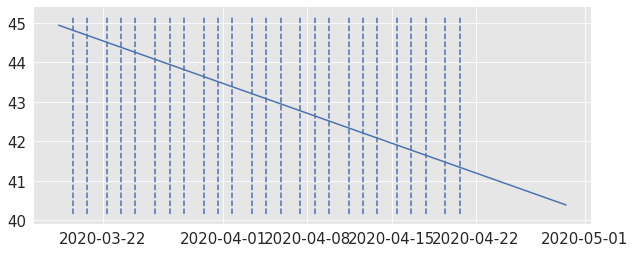

In [52]:
plt.figure(figsize=(10,4))

x = forecast_clientes.ds.values
y = forecast_clientes.trend.values
cp = mdl_prophet.changepoints

plt.plot(x,y)
ymin, ymax = plt.ylim()
plt.vlines(cp.values, ymin, ymax, linestyles="dashed")

In [53]:
# plot individual components
seasons = mdl_prophet.make_all_seasonality_features(forecast_clientes)

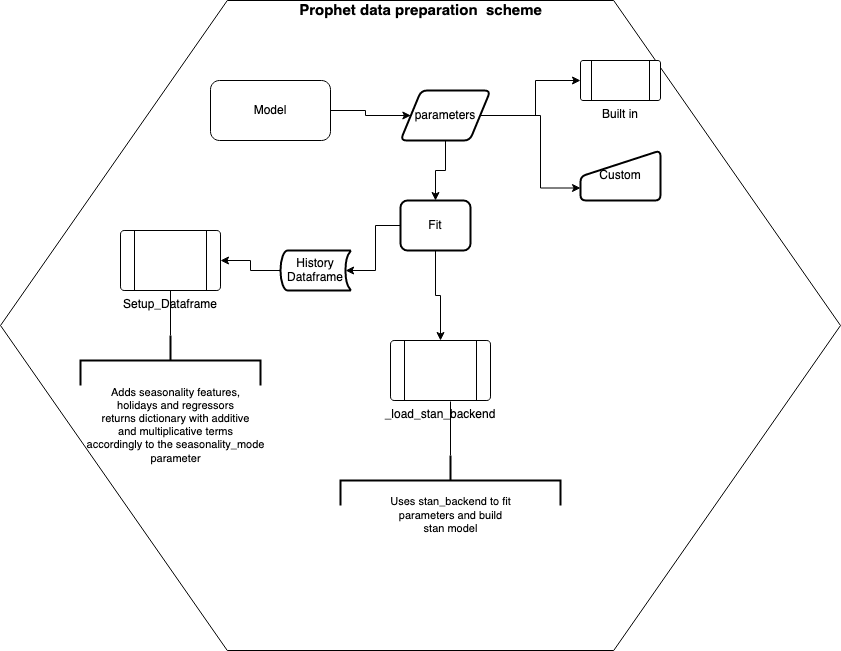

In [54]:
from IPython.display import Image
Image("img/Prophet_data_preparation_diagram.png")


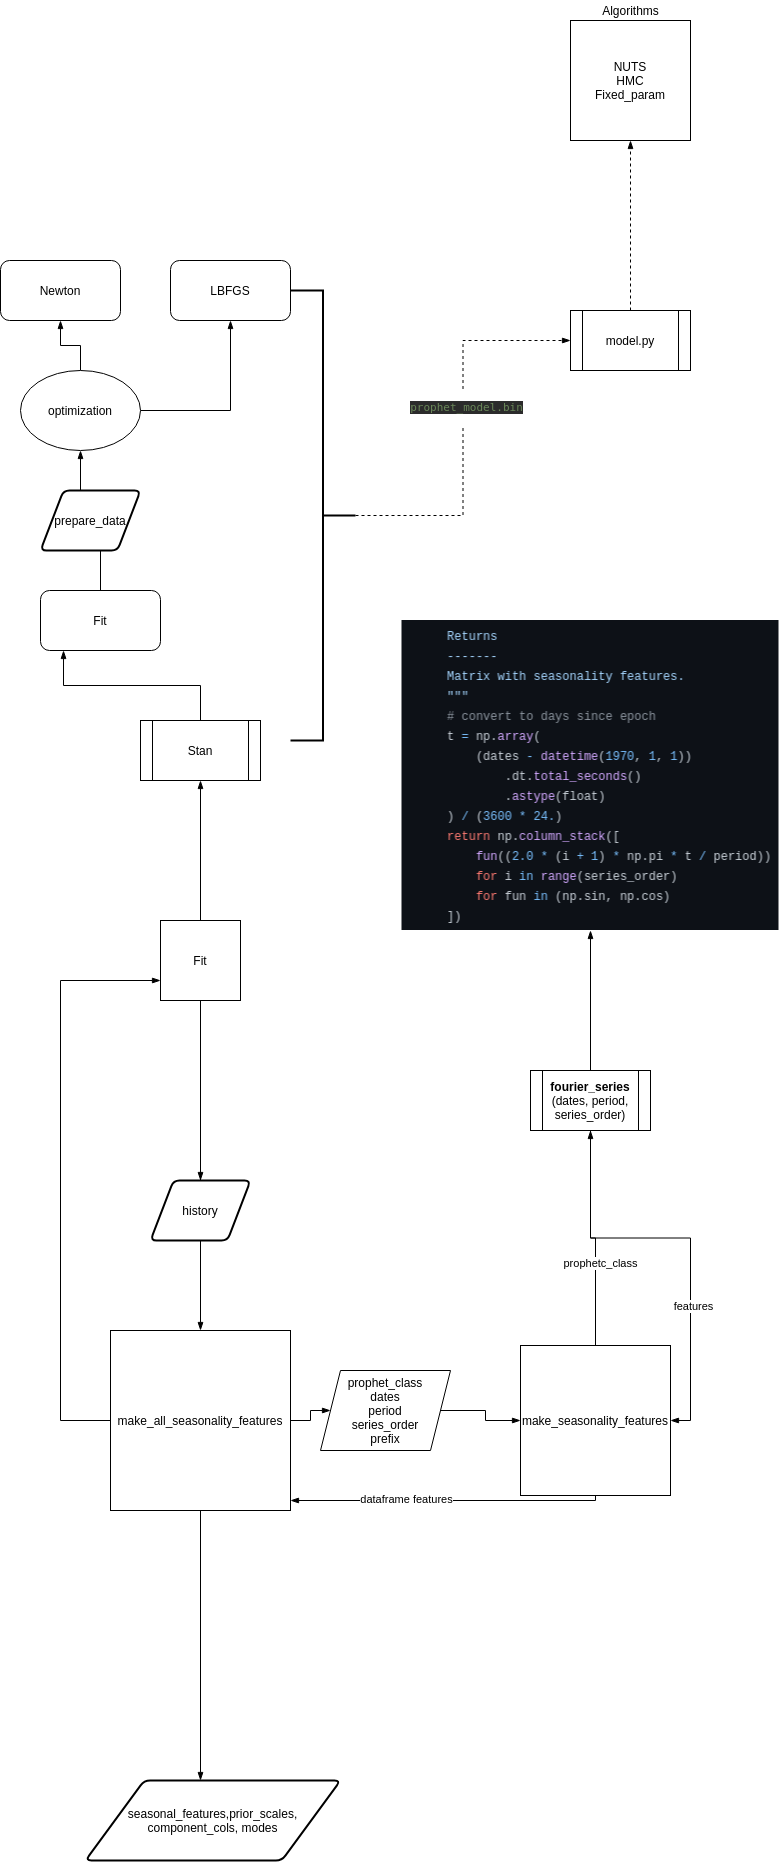

In [55]:
Image("img/make_all_seasonality_features.png")



In [49]:
list_columns=df_h_cli.columns
list_columns

Index(['index', 'ds', 'weekday', 'y', 'store'], dtype='object')

In [ ]:
table_new_dataset="fdata_tienda_ventas_caja"
df_hourly, df_daily = gendf.get_dataset_to_forecast(table_from_database)

In [69]:
df_large = read_large_files.read_large_file('sisqual_all.csv')

In [70]:
df_large.head()

store                   ds    y  n_clients
0      2  2015-01-02 10:00:00  121        2.0
1      2  2015-01-02 10:30:00   34        3.0
2      2  2015-01-02 10:45:00    2        1.0
3      2  2015-01-02 11:00:00   22        1.0
4      2  2015-01-02 11:15:00  109        4.0

In [72]:
df_large.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, store to n_clients
dtypes: object(1), float64(1), int64(2)

In [74]:
df_large.map_partitions(len).compute()

0    1048575
dtype: int64

In [75]:
df_large.partitions[0].compute()

store                   ds    y  n_clients
0            2  2015-01-02 10:00:00  121        2.0
1            2  2015-01-02 10:30:00   34        3.0
2            2  2015-01-02 10:45:00    2        1.0
3            2  2015-01-02 11:00:00   22        1.0
4            2  2015-01-02 11:15:00  109        4.0
...        ...                  ...  ...        ...
1048570     19  2019-12-17 16:30:00  115       23.0
1048571     19  2019-12-17 16:45:00   32       12.0
1048572     19  2019-12-17 17:00:00   55       19.0
1048573     19  2019-12-17 17:15:00  225       19.0
1048574     19  2019-12-17 17:30:00   71       23.0

[1048575 rows x 4 columns]

In [77]:
df_large.loc[:'store'].compute()

store                   ds    y  n_clients
0            2  2015-01-02 10:00:00  121        2.0
1            2  2015-01-02 10:30:00   34        3.0
2            2  2015-01-02 10:45:00    2        1.0
3            2  2015-01-02 11:00:00   22        1.0
4            2  2015-01-02 11:15:00  109        4.0
...        ...                  ...  ...        ...
1048570     19  2019-12-17 16:30:00  115       23.0
1048571     19  2019-12-17 16:45:00   32       12.0
1048572     19  2019-12-17 17:00:00   55       19.0
1048573     19  2019-12-17 17:15:00  225       19.0
1048574     19  2019-12-17 17:30:00   71       23.0

[1048575 rows x 4 columns]

In [79]:
df_large[df_large['store']== 2].compute()

store                   ds    y  n_clients
0          2  2015-01-02 10:00:00  121        2.0
1          2  2015-01-02 10:30:00   34        3.0
2          2  2015-01-02 10:45:00    2        1.0
3          2  2015-01-02 11:00:00   22        1.0
4          2  2015-01-02 11:15:00  109        4.0
...      ...                  ...  ...        ...
54794      2  2020-10-18 12:45:00   62        3.0
54795      2  2020-10-18 13:00:00   68        5.0
54796      2  2020-10-18 13:15:00  116        4.0
54797      2  2020-10-18 13:30:00   83        6.0
54798      2  2020-10-18 13:45:00  168        8.0

[54799 rows x 4 columns]

In [80]:
df_large.isna().sum(axis=0).compute()

store        0
ds           0
y            0
n_clients    0
dtype: int64

In [81]:
df_all = pd.read_csv(csvpath + '/' + 'sisqual_all.csv')

In [82]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   store      1048575 non-null  int64  
 1   ds         1048575 non-null  object 
 2   y          1048575 non-null  int64  
 3   n_clients  1048575 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 32.0+ MB


In [84]:
df_all.groupby("store")["n_clients"].count()

store
2     54799
3     64831
4     53428
5     57206
10    89245
11    89992
12    26727
13    93201
14    87934
15    95544
16    76798
17    79905
18    95318
19    83647
Name: n_clients, dtype: int64